### Laboratorium 4 - zadania

Jeśli nie posiadasz jeszcze pakietu `skimage`, zainstaluj go poniższym poleceniem:

In [6]:
# !pip install scikit-image

In [7]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries, slic
from qwlist import QList, Lazy

#### Zadanie 1

Dane są obrazy `hare` i `pills`. Wykonaj dla nich segmentację przy użyciu algorytmu SLIC. Celem jest uzyskanie jednolitych  superpikseli, a więc zawierających tylko fragmenty obiektów lub tylko tła (a nie jednego i drugiego naraz). Przeanalizuj zachowanie algorytmu dla różnej liczby superpikseli i parametru sigma.

Zwróć uwagę, że wynikiem działania scikitowej implementacji SLIC - [`skimage.segmentation.slic`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.slic) - (podobnie jak wielu innych algorytmów klasyfikacyjnych) jest obraz typu `np.int64` przyporządkowujący każdemu pikselowi obrazu wejściowego indeks superpiksela. Takiej reprezentacji oczekuje też funkcja [`mark_boundaries`](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.mark_boundaries).

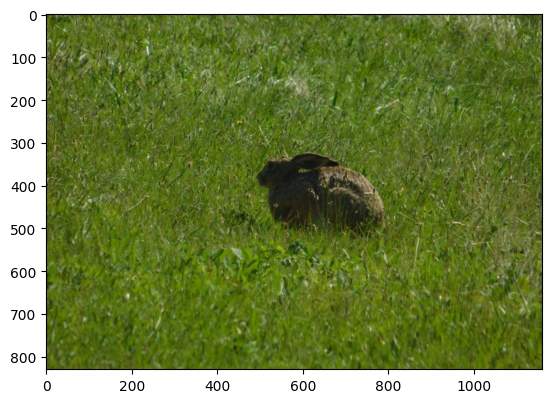

In [14]:
HARE = cv2.imread('../Dane1-4/Zajac_kolor.jpg')[..., ::-1]
plt.imshow(HARE);

In [30]:
def plot_segments(base_img, img, sigma, n_segments, ax):
    ax.imshow(mark_boundaries(base_img, img, outline_color=(1, 0.1, 1)))
    ax.axis('off')
    ax.set_title(f'n = {n_segments}, sigma = {sigma}')

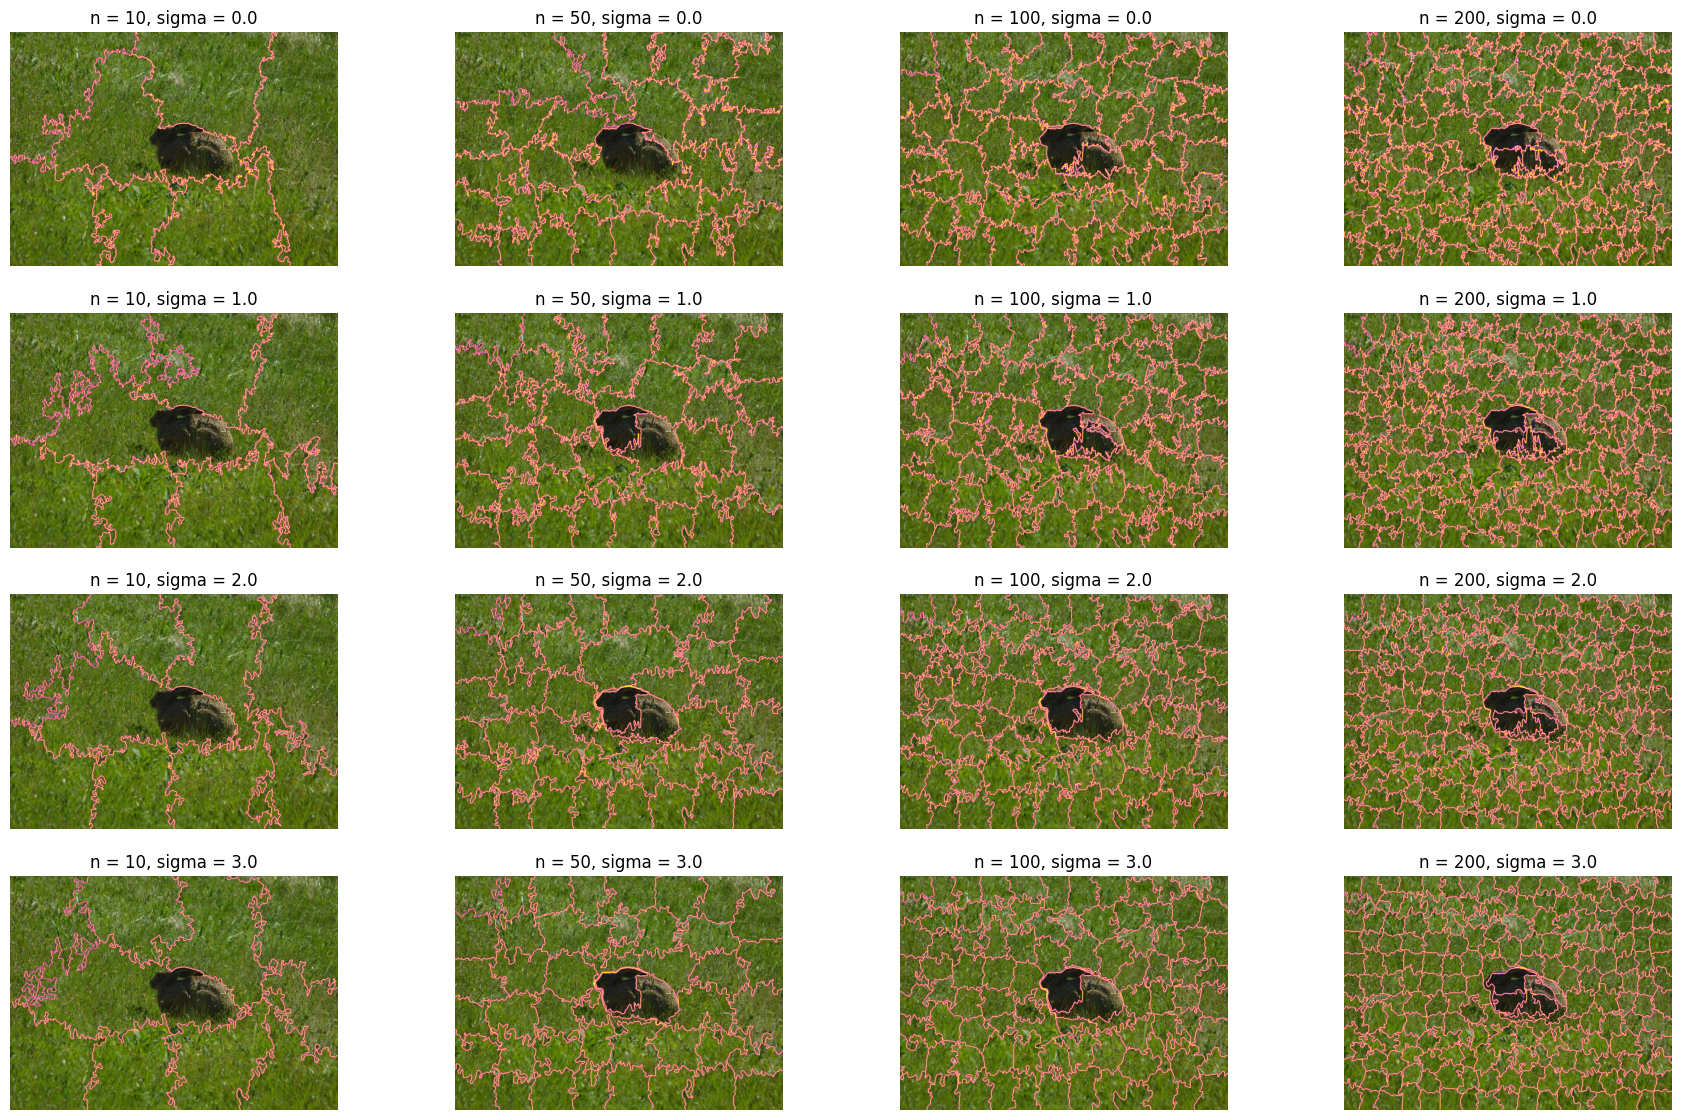

In [32]:
n_segments = [10, 50, 100, 200]
sigmas = [0.0, 1.0, 2.0, 3.0]

fig, axes = plt.subplots(len(sigmas), len(n_segments), figsize=(22, 14))

(
    QList(sigmas)
    .flatmap(lambda x: [(x, n) for n in n_segments])
    .zip(axes.flatten())
    .map(lambda s_n_ax: (HARE, slic(HARE, n_segments=s_n_ax[0][1], sigma=s_n_ax[0][0], start_label=0), s_n_ax[0][0], s_n_ax[0][1], s_n_ax[1]))
    .map(lambda args: plot_segments(*args))
    .collect()
);

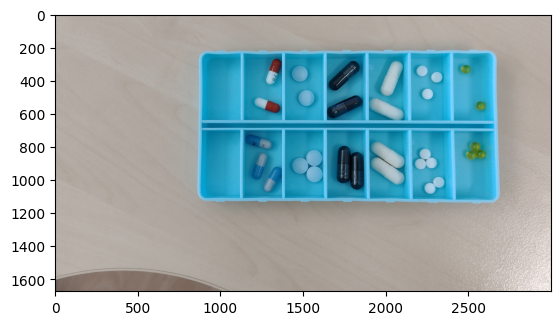

In [33]:
PILLS = cv2.imread('../Dane1-4/pills.png')[..., ::-1]
plt.imshow(PILLS);

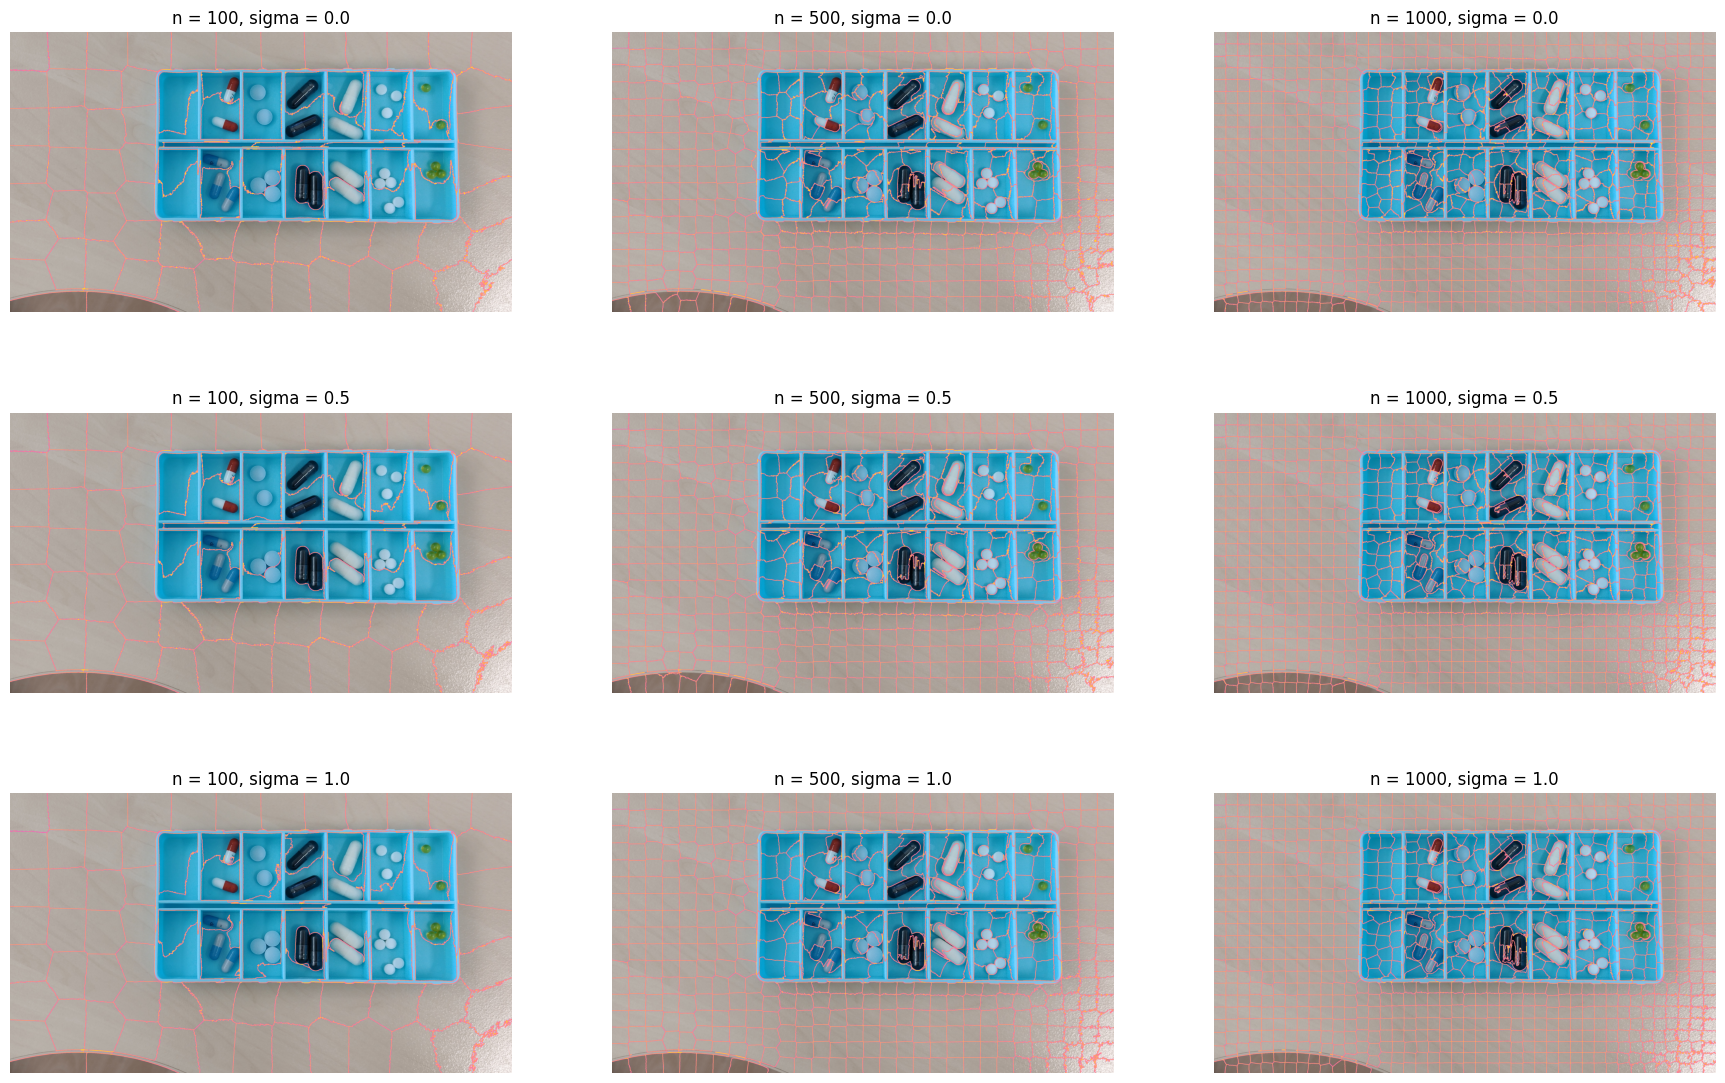

In [37]:
n_segments = [100, 500, 1000]
sigmas = [0.0, 0.5, 1.0]

fig, axes = plt.subplots(len(sigmas), len(n_segments), figsize=(22, 14))

(
    QList(sigmas)
    .flatmap(lambda x: [(x, n) for n in n_segments])
    .zip(axes.flatten())
    .map(lambda s_n_ax: (PILLS, slic(PILLS, n_segments=s_n_ax[0][1], sigma=s_n_ax[0][0], start_label=0), s_n_ax[0][0], s_n_ax[0][1], s_n_ax[1]))
    .map(lambda args: plot_segments(*args))
    .collect()
);

#### Zadanie 2

Dla obrazu `hare` wykonaj post-processing segmentacji SLIC by uzyskać dwa jednorodne obszary: jeden zawierający wyłącznie zająca, drugi zawierający wyłącznie trawę. Wykorzystaj dowolny algorytm klasteryzacji (np. [`cv2.kmeans`](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88)) by pogrupować superpiksele w dwie klasy, używając *cech* superpikseli uzyskanych w zadaniu 1 jako danych wejściowych. Najprostszymi cechami, którymi można opisać superpiksele, są np. średnie wartości składowych barwy (pikseli, z których składa się superpiksel) - od nich zacznij. Wersja "na piątkę": zaproponuj swoją własną cechę i rozszerz o nią reprezentację superpiksela, a następnie powtórz grupowanie.

Zaprezentuj wyniki najlepiej za pomocą `mark_boundaries` albo po prostu wyświetlając maskę binarną.

---

NumPy pro-tip: aby uzyskać zbiór wszystkich pikseli obrazu o wartości np. 3 możesz użyć notacji: ```obraz==3```. Wynikiem jest macierz boolowska, której można używać jako selektor. Np. aby na obrazie `A` wyzerować wszystkie piksele, którym w obrazie `B` odpowiada wartość 5, możesz napisać: ```A[B==5] = 0```. Ten zapis jest **znacznie** szybszy niż manualne iterowanie po obrazach i sprawdzanie warunków if-ami.

Przykładowe użycie `cv2.kmeans` (więcej możesz poczytać np. [tutaj](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html)):
```python
c, labels, centers = cv2.kmeans(
    data=data,  # np.ndarray typu float o wymiarach NxK gdzie N to liczba sampli (u nas: superpikseli), K - liczba cech
    K=2,        # oczekiwana liczba klastrów
    bestLabels=None,
    criteria=(cv2.TERM_CRITERIA_EPS, 10, 1.0),  # przykładowe kryteria stopu
    attempts=1, # liczba powtórzeń algorytmu
    flags=cv2.KMEANS_RANDOM_CENTERS  # sposób inicjalizacji klastrów
)
```

Funkcja ta zwraca krotkę, której najważniejszym komponentem jest ten drugi (tu: `labels`), tj. macierz o wymiarach Nx1, zawierająca indeks klastra przypisanego i-temu samplowi.

In [ ]:
# zacznij od przygotowania macierzy wejściowej (data) reprezentującej superpiksele jako punkty danych

Możesz wykorzystać poniższy snippet by zredukować wynik segmentacji SLIC (`segments`) w oparciu o klasteryzację k-średnich (`labels`):

In [ ]:
postprocessed = np.zeros_like(segments)
for i in range(labels.shape[0]):
    postprocessed[segments==i] = labels[i] # jeśli używamy indeksowania od 0 w SLIC
    postprocessed[segments==i+1] = labels[i] # jeśli używamy indeksowania od 1